# LV 4: Word Embeddings i Semantička Sličnost

---

## 1. Uvod u Word Embeddings

Word embeddings predstavljaju tehniku prikaza riječi u numeričkom obliku ("vektori riječi") gdje su slične riječi (po značenju) smještene blizu u vektorskom prostoru. Umjesto rada s pojedinačnim riječima, tekstualne podatke modeliramo kao skup vektora koji dobro zadržavaju semantičke odnose. Time omogućujemo računalima napredno razumijevanje značenja riječi, pa se embeddingi koriste u zadacima poput prepoznavanja sinonima, pronalaženja antonima, mjerenja sličnosti rečenica i mnogim naprednim aplikacijama obrade jezika.

### Najčešće korištene tehnike:
- **Word2Vec**: model treniran na temelju konteksta riječi (CBOW i Skip-gram)
- **GloVe** (Global Vectors): kombinira globalnu statistiku i lokalni kontekst
- **FastText**: proširenje Word2Veca koje uključuje podriječi

### Korištenjem pretreniranih modela embeddinga možemo:
- Lako pronaći slične i suprotne riječi
- Vizualizirati prostorne odnose između pojmova (PCA, t-SNE)
- Mjeriti sličnost između rečenica ili dokumenata
- Koristiti embeddinge kao ulazne podatke za napredne NLP modele

Nakon ove vježbe studenti će moći raditi s embeddingima, razumjeti kako oni predstavljaju značenje riječi te koristiti embeddinge za analizu sličnosti i semantičkih odnosa u tekstu.

---



## 2. Korištene biblioteke

U ovoj vježbi koristimo:

**gensim**  
Biblioteka za rad s word embeddingima, uključuje:
- Učitavanje pretreniranih Word2Vec i GloVe modela
- Računanje semantičke sličnosti
- Operacije s vektorima riječi

**scikit-learn**  
Za smanjenje dimenzionalnosti i vizualizaciju (PCA, t-SNE).

**matplotlib**  
Za crtanje grafova i vizualizacija embedding prostora.

**numpy**  
Za matematičke operacije s vektorima.

---


In [1]:
!pip install -q gensim numpy matplotlib scikit-learn


[notice] A new release of pip is available: 25.0 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
import gensim.downloader as api
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

## 3. Inicijalizacija okruženja i učitavanje modela

---

### Primjer: Učitavanje pretreniranog Word2Vec modela

Gensim biblioteka omogućuje jednostavno preuzimanje različitih pretreniranih modela. U ovom primjeru koristimo **glove-wiki-gigaword-50**, manji model (50 dimenzija) pogodan za brzo testiranje.

Možete koristiti i veće modele poput:
- `glove-wiki-gigaword-100`
- `glove-wiki-gigaword-200`
- `word2vec-google-news-300` (vrlo velik, potrebno više vremena)


In [3]:
print("Učitavanje modela...")
model = api.load("glove-wiki-gigaword-50")
print("Model uspješno učitan!")

print(f"Broj riječi u modelu: {len(model)}")

Učitavanje modela...
Model uspješno učitan!
Broj riječi u modelu: 400000


---

### Primjer: Prikaz vektora riječi

Svaka riječ u modelu ima svoj vektor (niz brojeva). Duljina vektora ovisi o modelu – ovdje je 50 dimenzija.

Demonstracija kako izgleda embedding za riječ "king".


In [4]:
vector_king = model['king']

print(f"Vektor za riječ 'king' (prvih 10 vrijednosti):")
print(vector_king[:10])

print(f"\nDuljina vektora: {len(vector_king)}")
print(f"Tip podatka: {type(vector_king)}")


Vektor za riječ 'king' (prvih 10 vrijednosti):
[ 0.50451   0.68607  -0.59517  -0.022801  0.60046  -0.13498  -0.08813
  0.47377  -0.61798  -0.31012 ]

Duljina vektora: 50
Tip podatka: <class 'numpy.ndarray'>


---

### Primjer: Računanje sličnosti između dviju riječi

Embeddings omogućuju mjerenje semantičke sličnosti. Model računa **kosinusnu sličnost** između vektora dviju riječi. Vrijednost je između 0 (potpuno različite) i 1 (identične).


In [5]:

similarity = model.similarity('king', 'queen')
print(f"Sličnost između 'king' i 'queen': {similarity:.4f}")

similarity2 = model.similarity('king', 'apple')
print(f"Sličnost između 'king' i 'apple': {similarity2:.4f}")

similarity3 = model.similarity('computer', 'laptop')
print(f"Sličnost između 'computer' i 'laptop': {similarity3:.4f}")


Sličnost između 'king' i 'queen': 0.7839
Sličnost između 'king' i 'apple': 0.3047
Sličnost između 'computer' i 'laptop': 0.7741


---

### Primjer: Pronalaženje sličnih riječi

Možemo pronaći riječi koje su najbliže (najsličnije) odabranoj riječi, korisno za traženje sinonima.


In [6]:

similar_words = model.most_similar('king', topn=5)

print("5 najsličnijih riječi za 'king':")
for word, score in similar_words:
    print(f"  {word}: {score:.4f}")


5 najsličnijih riječi za 'king':
  prince: 0.8236
  queen: 0.7839
  ii: 0.7746
  emperor: 0.7736
  son: 0.7667


---

### Primjer: Semantičke operacije – Vektorska aritmetika

Jedan od najpoznatijih primjera word embeddinga je **king - man + woman ≈ queen**.

Ovim pristupom možemo "računati" sa značenjima riječi.


In [7]:
# King - man + woman = ?
result = model.most_similar(positive=['king', 'woman'], negative=['man'], topn=1)

print("king - man + woman =")
print(f"  {result[0][0]} (sličnost: {result[0][1]:.4f})")

# Paris - France + Italy = ?
result2 = model.most_similar(positive=['paris', 'italy'], negative=['france'], topn=3)

print("\nparis - france + italy =")
for word, score in result2:
    print(f"  {word}: {score:.4f}")


king - man + woman =
  queen (sličnost: 0.8524)

paris - france + italy =
  rome: 0.8466
  milan: 0.7766
  turin: 0.7666


---

### Primjer: Vizualizacija embeddinga pomoću PCA

PCA (Principal Component Analysis) je linearni algoritam koji smanjuje broj dimenzija vektora, zadržavajući što više informacija. Koristimo ga za prikaz riječi u 2D prostoru.

Ovdje ćemo vizualizirati nekoliko odabranih riječi iz različitih domena.


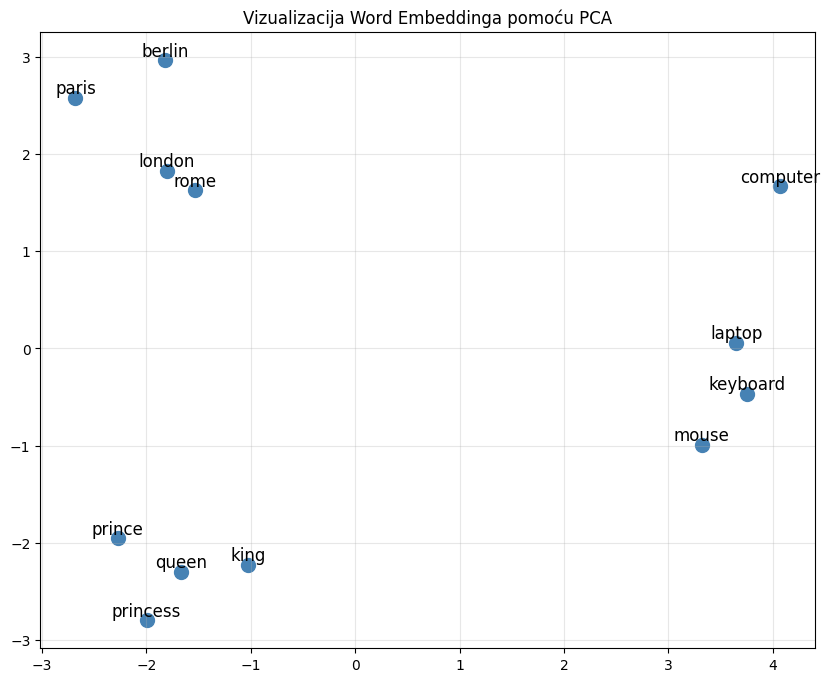

In [8]:
words = ['king', 'queen', 'prince', 'princess',
         'paris', 'london', 'berlin', 'rome',
         'computer', 'laptop', 'keyboard', 'mouse']

word_vectors = np.array([model[word] for word in words])

pca = PCA(n_components=2)
coords = pca.fit_transform(word_vectors)

plt.figure(figsize=(10, 8))
plt.scatter(coords[:, 0], coords[:, 1], s=100, color='steelblue')

for i, word in enumerate(words):
    plt.annotate(word, xy=(coords[i, 0], coords[i, 1]),
                 fontsize=12, ha='center', va='bottom')

plt.title('Vizualizacija Word Embeddinga pomoću PCA')
plt.grid(True, alpha=0.3)
plt.show()

---

### Primjer: Vizualizacija embeddinga pomoću t-SNE

t-SNE (t-Distributed Stochastic Neighbor Embedding) je nelinearna tehnika koja bolje čuva lokalne odnose između riječi. Često daje preglednije klastere nego PCA.

**Napomena**: t-SNE može davati različite rezultate pri svakom pokretanju zbog stohastičke prirode algoritma.


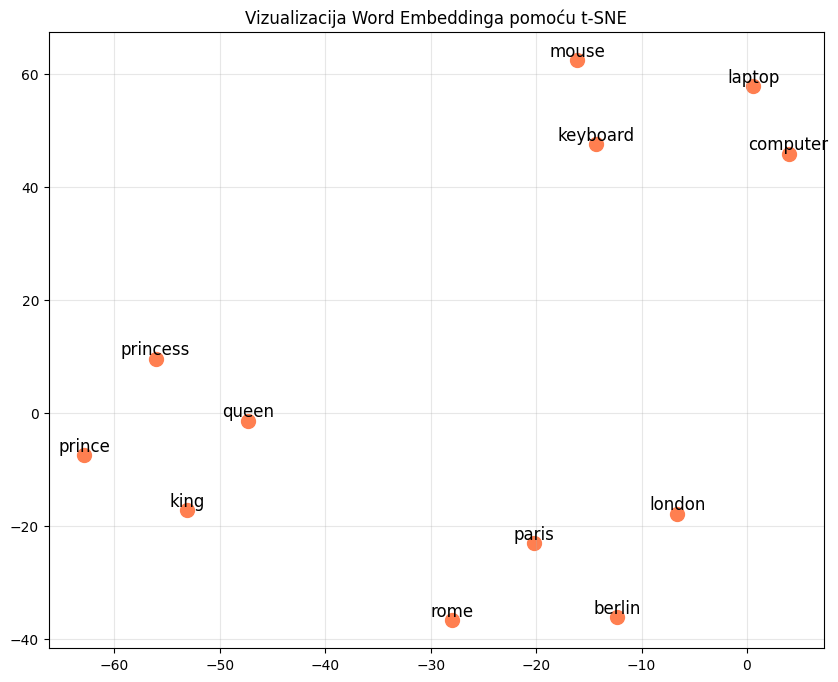

In [9]:
tsne = TSNE(n_components=2, random_state=42, perplexity=5)
coords_tsne = tsne.fit_transform(word_vectors)

plt.figure(figsize=(10, 8))
plt.scatter(coords_tsne[:, 0], coords_tsne[:, 1], s=100, color='coral')

for i, word in enumerate(words):
    plt.annotate(word, xy=(coords_tsne[i, 0], coords_tsne[i, 1]),
                 fontsize=12, ha='center', va='bottom')

plt.title('Vizualizacija Word Embeddinga pomoću t-SNE')
plt.grid(True, alpha=0.3)
plt.show()

---

### Primjer: Računanje sličnosti rečenica

Isti pristup možemo proširiti i na rečenice: najjednostavniji način je izračunati prosječni embedding, odnosno prosjek vektora svih riječi u rečenici.

**Napomena**: Ova metoda ne uzima u obzir redoslijed riječi, ali daje korisnu aproksimaciju semantičke sličnosti.


In [10]:
def sentence_vector(sentence, model):
    words = [word.lower() for word in sentence.split() if word.lower() in model]
    if not words:
        return np.zeros(model.vector_size)
    return np.mean([model[word] for word in words], axis=0)

def sentence_similarity(sent1, sent2, model):
    vec1 = sentence_vector(sent1, model)
    vec2 = sentence_vector(sent2, model)

    dot_product = np.dot(vec1, vec2)
    norm1 = np.linalg.norm(vec1)
    norm2 = np.linalg.norm(vec2)

    if norm1 == 0 or norm2 == 0:
        return 0.0

    return dot_product / (norm1 * norm2)


s1 = "The cat sits on the mat."
s2 = "A dog rests on the carpet."
s3 = "I love programming in Python."

print(f"Sličnost između rečenica 1 i 2: {sentence_similarity(s1, s2, model):.4f}")
print(f"Sličnost između rečenica 1 i 3: {sentence_similarity(s1, s3, model):.4f}")
print(f"Sličnost između rečenica 2 i 3: {sentence_similarity(s2, s3, model):.4f}")

Sličnost između rečenica 1 i 2: 0.9715
Sličnost između rečenica 1 i 3: 0.8037
Sličnost između rečenica 2 i 3: 0.8108


## Zadatak 1: Istraživanje semantičkih odnosa i vektorska aritmetika

Koristite učitani Word2Vec/GloVe model za istraživanje semantičkih odnosa između riječi. Pronađite sinonime, testirajte vektorsku aritmetiku i analizirajte rezultate.



1. Pronađite 10 najsličnijih riječi za pojam "doctor"
2. Pronađite 10 najsličnijih riječi za pojam "technology"
3. Testirajte vektorsku aritmetiku:
   - king - man + woman = ?
   - doctor - man + woman = ?
   - berlin - germany + france = ?
   - python - programming + cooking = ?
4. Analizirajte rezultate i objasnite koje analogije model dobro prepoznaje, a gdje griješi


In [11]:
# Zadatak 1: Istraživanje semantičkih odnosa i vektorska aritmetika

## Zadatak 2: Detekcija outliera - koja riječ ne pripada grupi?





Implementirajte funkciju koja detektira koja riječ ne pripada grupi sličnih riječi. Ovo je praktična primjena u analizi teksta i detekciji anomalija

**Napomena**:  Koristite embedding model za pronalaženje "outliera".

Testirajte sljedeće grupe riječi i pronađite koja riječ ne pripada:

1. ['breakfast', 'lunch', 'dinner', 'cement']
2. ['cat', 'dog', 'mouse', 'computer']
3. ['paris', 'london', 'berlin', 'table']
4. ['happy', 'joyful', 'cheerful', 'angry']
5. ['python', 'java', 'javascript', 'banana']

Za svaku grupu:
- Pronađite outlier riječ
- Izračunajte njenu prosječnu sličnost s ostalim riječima
- Objasnite zašto je detektirana kao outlier


In [12]:
test_groups = [
    ['breakfast', 'lunch', 'dinner', 'cement'],
    ['cat', 'dog', 'mouse', 'computer'],
    ['paris', 'london', 'berlin', 'table'],
    ['happy', 'joyful', 'cheerful', 'angry'],
    ['python', 'java', 'javascript', 'banana']
]

In [13]:
# Zadatak 2: Detekcija outliera

## Zadatak 3: Vizualizacija tematskih klastera pomoću PCA i t-SNE


Vizualizirajte embedding prostor za riječi iz različitih domena (hrana, tehnologija, sport, gradovi). Usporedite PCA i t-SNE vizualizacije.

Koristite sljedeće riječi iz 4 kategorije:
- Hrana: ['pizza', 'burger', 'pasta', 'salad', 'bread']
- Tehnologija: ['computer', 'laptop', 'smartphone', 'tablet', 'software']
- Sport: ['football', 'basketball', 'tennis', 'swimming', 'running']
- Gradovi: ['paris', 'london', 'tokyo', 'berlin', 'rome']

Zadaci:
1. Vizualizirajte sve riječi pomoću PCA u 2D prostoru
2. Vizualizirajte iste riječi pomoću t-SNE
3. Obojite svaku kategoriju različitom bojom
4. Usporedite rezultate i objasnite razlike između PCA i t-SNE


In [14]:
categories = {
    'Hrana': ['pizza', 'burger', 'pasta', 'salad', 'bread'],
    'Tehnologija': ['computer', 'laptop', 'smartphone', 'tablet', 'software'],
    'Sport': ['football', 'basketball', 'tennis', 'swimming', 'running'],
    'Gradovi': ['paris', 'london', 'tokyo', 'berlin', 'rome']
}

In [15]:
# Zadatak 3: Vizualizacija tematskih klastera

## Zadatak 4: Semantička sličnost rečenica i analiza tekstova



Implementirajte funkciju za mjerenje sličnosti rečenica i testirajte na različitim parovima rečenica te analizirajte gdje metoda radi dobro, a gdje ima ograničenja.


Funkciju testirajte je na sljedećim parovima rečenica:

1. "The cat sits on the mat." vs "A cat is sitting on a rug."
2. "I love programming in Python." vs "Python programming is my passion."
3. "The weather is nice today." vs "I enjoy coding in Python."
4. "Machine learning is fascinating." vs "Artificial intelligence is interesting."
5. "How do I reset my password?" vs "I forgot my password, how to recover it?"
6. "The quick brown fox jumps." vs "A fast auburn fox leaps."

Zadaci:
1. Implementirajte funkciju sentence_similarity() koja računa prosječni embedding
2. Izračunajte sličnost za sve parove
3. Analizirajte rezultate - koje parove model prepoznaje kao slične?
4. Identificirajte ograničenja metode prosječnog embeddinga
5. Predložite moguća poboljšanja


In [16]:
sentence_pairs = [
    ("The cat sits on the mat.", "A cat is sitting on a rug."),
    ("I love programming in Python.", "Python programming is my passion."),
    ("The weather is nice today.", "I enjoy coding in Python."),
    ("Machine learning is fascinating.", "Artificial intelligence is interesting."),
    ("How do I reset my password?", "I forgot my password, how to recover it?"),
    ("The quick brown fox jumps.", "A fast auburn fox leaps.")
]

In [17]:
# Zadatak 4: Semantička sličnost rečenica